# Прогнозирование оттока клиентов телеком-компании

Оператор связи для минимизации убытков хочет прогнозировать отток клиентов. Если обнаружится, что клиент собирается уходить, то ему будут предложены промокоды или специальные условия, чтобы удержать его.

**Цель работы** -- построение модели, которая будет предсказывать уход клиента.

**Входные данные** -- информация о клиентах, данные об их договорах и используемых услугах (на 01.02.2020).

**План проекта**
 1. **Предобработка данных** (проверка данных на пропуски/дубликаты/аномалии и исправление обнаруженных ошибок)
 0. **Подготовка данных** (объединение таблиц, генерация новых признаков и/или удаление лишних)
 0. **Исследовательский анализ данных** (построение распределений признаков, определение закономерностей)
 0. **Обучение и сравнение моделей** (выбор нескольких моделей, определение оптимальных гиперпараметров и обучение на кросс-валидации, выбор лучшей модели)
 0. **Тестирование лучшей модели**
 0. **Составление отчёта** (краткое описание предпринятых шагов, обозначение возникших проблем и их решений, представление полученных результатов)

Перед началом работы проведём предварительный анализ имеющихся данных.

In [1]:
import pandas as pd
import numpy as np

*Информация о договорах*

In [2]:
try:
    contract = pd.read_csv('final_provider/contract.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')

In [3]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


В таблице 8 столбцов с различными типами данных:
 - `customerID` — код клиента;
 - `BeginDate` — дата начала пользования услугами;
 - `EndDate` — дата окончания пользования услугами;
 - `Type` — тип оплаты;
 - `PaperlessBilling` — безналичный расчёт;
 - `PaymentMethod` — способ оплаты;
 - `MonthlyCharges` — ежемесячные траты на услуги;
 - `TotalCharges` — общие траты на услуги.
 
На первый взгляд пропусков нет (количество строк во всех столбцах совпадает). Однако можно заметить, что тип `TotalCharges` не является числовым. Т.е. некоторые значения не удалось преобразовать в число. Выясним, с чем это связано.

In [5]:
mask = pd.to_numeric(contract['TotalCharges'], errors='coerce').isna()
print(mask.sum())
print(contract[mask]['TotalCharges'].unique())
print(contract[mask]['BeginDate'].unique())

11
[' ']
['2020-02-01']


Видим 11 пропусков, которые обозначены пробелами. Причём все эти записи для даты начала пользования услугами 01.02.2020. Это именно дата актуализации имеющихся данных. Таким образом, пропуски вполне объяснимы -- они наблюдаются у новых пользователей. Эти пропуски в дальнейшей предобработке можно будет заполнить месячной платой из столбца `MonthlyCharges`.

*Данные о клиентах*

In [6]:
try:
    personal = pd.read_csv('final_provider/personal.csv')
except:
    personal = pd.read_csv('/datasets/final_provider/personal.csv')

In [7]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [8]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Таблица содержит 5 столбцов:
 - `customerID` — код клиента;
 - `gender` — пол клиента;
 - `SeniorCitizen` — пенсионный статус;
 - `Partner` — наличие супруга(-и);
 - `Dependents` — наличие иждивенцев.
 
Явных пропусков не обнаружено. Для удобства и единообразия можно будет преобразовать значения в `SeniorCitizen` из `0/1` в `No/Yes`. 

*Интернет-услуги*

In [9]:
try:
    internet = pd.read_csv('final_provider/internet.csv')
except:
    internet = pd.read_csv('/datasets/final_provider/internet.csv')

In [10]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [11]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


В таблице 8 столбцов с различными типами данных:
 - `customerID` — код клиента;
 - `InternetService` — тип подключения;
 - `OnlineSecurity` — блокировка небезопасных сайтов;
 - `OnlineBackup` — резервное копирвоание;
 - `DeviceProtection` — антивирус;
 - `TechSupport` — техническая поддержка;
 - `StreamingTV` — стриминговое телевидение;
 - `StreamingMovies` — каталог фильмов.
 
В целом выглядит так, что всё в порядке. Но бросается в глаза отличие числа записей от количества в первых двух файлах. Вероятно, это объясняется тем, что не все пользователи используют интернет.

*Услуги телефонной связи*

In [12]:
try:
    phone = pd.read_csv('final_provider/phone.csv')
except:
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [13]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [14]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Таблица всего содержит 2 столбца:
 - `customerID` — код клиента;
 - `MultipleLines` — подключение телефона к нескольким линиям.
 
Так же, как и для данных по интернету, наблюдается отличие числа записей от числа договоров, т.е. не все клиенты пользуются телефонной связью.

**Выводы**

После первичного ознакомления с данными можно заключить следующее:
 - необходимо изменить названия столбцов во всех таблицах для соответствия стилю;
 - необходимо обработать пропуски в таблице `contract`;
 - т.к. количество записей в разных таблицах отличается, то после объединения таблиц необходимо будет заполнить образовавшиеся пропуски;
 - явно выделенного целевого признака нет, но его можно восстановить по столбцу `EndDate` таблицы `contract`;
 - признаки `BeginDate` и `EndDate` можно будет заменить на числовой признак (предварительно, на число дней или месяцев).

Перейдём к основной части проекта. Для начала импортируем все необходимые библиотеки, а также зафиксируем random_state. 

In [15]:
# если этого модуля нет, нужно раскомментировать следующую строчку и запустить
#pip install catboost

In [16]:
# если этого модуля нет, нужно раскомментировать следующую строчку и запустить
#pip install phik

In [17]:
# импорт необходимых библиотек
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from catboost import CatBoostClassifier
import phik
from phik.report import plot_correlation_matrix

In [18]:
RANDOM_STATE = 171022

## Предобработка данных

### Переименование столбцов

Приведём названия столбцов в соответствие с общепринятым стилем и для удобства дальенейшей работы с данными.

In [19]:
contract.rename(columns={'customerID': 'customer_id',
                         'BeginDate': 'begin_date',
                         'EndDate': 'end_date',
                         'Type': 'type',
                         'PaperlessBilling': 'paperless_billing',
                         'PaymentMethod': 'payment_method',
                         'MonthlyCharges': 'monthly_charges',
                         'TotalCharges': 'total_charges'},
                inplace=True)
contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [20]:
personal.rename(columns={'customerID': 'customer_id',
                         'SeniorCitizen': 'senior_citizen',
                         'Partner': 'partner',
                         'Dependents': 'dependents'},
                inplace=True)
personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [21]:
internet.rename(columns={'customerID': 'customer_id',
                         'InternetService': 'internet_service',
                         'OnlineSecurity': 'online_security',
                         'OnlineBackup': 'online_backup',
                         'DeviceProtection': 'device_protection',
                         'TechSupport': 'tech_support',
                         'StreamingTV': 'streaming_tv',
                         'StreamingMovies': 'streaming_movies'},
                inplace=True)
internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [22]:
phone.rename(columns={'customerID': 'customer_id',
                      'MultipleLines': 'multiple_lines'},
             inplace=True)
phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

### Объединение таблиц

Объединим данные из четырёх таблиц в один датафрейм, с которым далее и будем работать.

In [23]:
data = (contract.set_index('customer_id')
        .join([personal.set_index('customer_id'),
               internet.set_index('customer_id'),
               phone.set_index('customer_id')],
              how='outer')).reset_index()
data.sample(10)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
3674,7825-GKXMW,2019-12-01,2020-01-01 00:00:00,Month-to-month,No,Electronic check,45.80,45.8,Female,0,No,No,DSL,No,No,No,No,No,No,No
1084,9170-ARBTB,2015-10-01,No,One year,No,Credit card (automatic),19.60,1012.4,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1660,1171-TYKUR,2016-03-01,No,Month-to-month,No,Electronic check,25.40,1139.2,Male,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
5305,9027-TMATR,2016-07-01,No,Two year,Yes,Electronic check,78.80,3460.3,Female,0,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,No
6749,8469-SNFFH,2014-04-01,No,One year,No,Bank transfer (automatic),79.40,5528.9,Male,0,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,No,Yes
1422,3870-SPZSI,2014-04-01,No,Two year,Yes,Credit card (automatic),113.05,7869.05,Female,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
869,0323-XWWTN,2019-11-01,No,Two year,Yes,Mailed check,26.40,121.25,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
932,5787-KXGIY,2014-02-01,No,Two year,No,Credit card (automatic),19.30,1304.8,Male,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1931,7409-JURKQ,2015-09-01,No,One year,Yes,Bank transfer (automatic),111.80,5809.75,Female,0,Yes,No,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes
4305,0559-CKHUS,2017-09-01,No,Two year,Yes,Mailed check,19.55,521.8,Female,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

Как было отмечено выше, после объединения таблиц у нас возникли закономерные пропуски в некоторых столбцах. К тому же у нас имелись пропуски в столбце с общими тратами. Перейдём к обработке этих пропусков.

### Обработка пропусков

Для того, чтобы выделить пользователей, которые не используют интернет или телефонию, пропуски в столбцах `internet_service` и `multiple_lines` имеет смысл заполнить значением `Not used`, например.

In [25]:
data.fillna({'internet_service': 'Not used', 'multiple_lines': 'Not used'}, 
            inplace=True)
data.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines          0
dtype: int64

В остальных столбцах, касаемых интернет-услуг, пропуски можно заполнить значением `No`.

In [26]:
data.fillna('No', inplace=True)
data.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

Теперь заполним пропуски в столбце `total_charges`.

In [27]:
data['total_charges'] = pd.to_numeric(data['total_charges'], errors='coerce')
data['total_charges'].fillna(data['monthly_charges'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   object 
 14  online_backup      7043 non-null   object 
 15  device_protection  7043 non-null   object 
 16  tech_support       7043 

### Дополнительные операции

In [28]:
# проверка значений в категориальных признаках
for col in (set(data.columns.to_list()) -
            set(['customer_id', 'begin_date', 'end_date',
                 'monthly_charges', 'total_charges'])):
    print(f'{col}: {data[col].unique()}')

gender: ['Female' 'Male']
device_protection: ['No' 'Yes']
streaming_tv: ['No' 'Yes']
dependents: ['No' 'Yes']
senior_citizen: [0 1]
tech_support: ['No' 'Yes']
payment_method: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
streaming_movies: ['No' 'Yes']
paperless_billing: ['Yes' 'No']
online_backup: ['Yes' 'No']
multiple_lines: ['Not used' 'No' 'Yes']
type: ['Month-to-month' 'One year' 'Two year']
internet_service: ['DSL' 'Fiber optic' 'Not used']
partner: ['Yes' 'No']
online_security: ['No' 'Yes']


In [29]:
# проверка на дубликаты
data.duplicated().sum()

0

In [30]:
# приведение begin_date и end_date к формату даты
data['begin_date'] = pd.to_datetime(data['begin_date'])
data['end_date'] = pd.to_datetime(data['end_date'], errors='coerce')

In [31]:
# замена 0/1 в senior_citizen на No/Yes
data['senior_citizen'].replace({1: 'Yes', 0: 'No'}, inplace=True)
data['senior_citizen'].value_counts()

No     5901
Yes    1142
Name: senior_citizen, dtype: int64

In [32]:
data.sample(10)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
4571,0599-XNYDO,2018-06-01,NaT,Month-to-month,Yes,Bank transfer (automatic),69.80,1540.35,Female,No,Yes,No,Fiber optic,No,No,No,No,No,No,No
1329,3910-MRQOY,2014-02-01,NaT,Two year,No,Bank transfer (automatic),19.40,1496.45,Female,No,Yes,No,Not used,No,No,No,No,No,No,No
3368,1370-GGAWX,2016-04-01,NaT,One year,Yes,Electronic check,94.15,4408.45,Female,No,No,No,Fiber optic,No,Yes,Yes,No,No,Yes,Yes
2342,1552-AAGRX,2017-08-01,NaT,Month-to-month,No,Bank transfer (automatic),106.40,3211.90,Female,No,No,No,Fiber optic,Yes,No,No,Yes,Yes,Yes,Yes
2382,6114-TCFID,2017-09-01,NaT,One year,No,Credit card (automatic),39.50,1082.75,Female,No,No,No,DSL,Yes,Yes,No,Yes,No,No,Not used
5889,9693-XMUOB,2015-03-01,NaT,Month-to-month,Yes,Electronic check,50.25,2997.45,Male,Yes,Yes,No,DSL,No,Yes,No,No,Yes,Yes,Not used
5422,3563-SVYLG,2014-06-01,NaT,Two year,No,Credit card (automatic),62.65,4375.80,Male,No,Yes,Yes,DSL,Yes,Yes,Yes,Yes,No,No,No
2394,8231-BSWXX,2014-03-01,NaT,One year,Yes,Credit card (automatic),79.05,5552.50,Male,No,No,No,Fiber optic,No,Yes,No,No,No,No,Yes
5413,6833-JMZYP,2018-11-01,NaT,Month-to-month,Yes,Credit card (automatic),94.00,1505.45,Female,No,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,No
2681,9674-EHPPG,2016-04-01,NaT,Two year,No,Credit card (automatic),40.40,1842.70,Male,No,Yes,No,DSL,Yes,No,Yes,Yes,No,No,Not used


**Выводы**

На этапе предобработки данных были проделаны следующие преобразования:
 - названия столбцов приведены к *snake_case*;
 - данные объединены в единую таблицу `data`;
 - обработаны пропуски (как исходные, так и образованные в результате объединения);
 - тип данных `begin_date` приведён к *datetime*;
 - *0/1* в `senior_citizen` приведены к *No/Yes*.
 
Столбец `end_date` намеренно не подвергся обработке, т.к. далее на основании него будет проводиться подготовка данных, а текущее его состояние видится для этого наиболее удобным.

## Подготовка данных

Для начала добавим столбец в целевым признаком. Отсутствие значния в `end_date`, означает, что клиент ещё пользуется услугами. Наоборот, если указана дата окончания пользования услугами, то пользователь ушёл.

In [33]:
data['churn'] = data['end_date'].isna().replace({True: 0, False: 1})
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,No,...,No,DSL,No,Yes,No,No,No,No,Not used,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,No,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,No,...,No,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,No,...,No,DSL,Yes,No,Yes,Yes,No,No,Not used,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,No,...,No,Fiber optic,No,No,No,No,No,No,No,1


Сами по себе даты особой нагрузки не несут. Однако можно извлечь из них количесвенный признак -- число дней пользования услугами. Добавим новый столбец. Перед этим заполним пропуски в `end_date` на дату актуализации данных -- 01.02.2020.

In [34]:
# заполнение пропусков в end_date
data['end_date'].fillna(np.datetime64('2020-02-01'), inplace=True)

In [35]:
# добавление столбца с числом дней
data['days'] = (data['end_date'] - data['begin_date']).dt.days

После добавления нового признака, столбцы `begin_date` и `end_date` необходимо удалить (они уже являются лишними, к тому же через них может произойти утечка целевого признака). Идентификатор пользователя так же не несёт какой-либо важной информации. 

In [36]:
# удаление столбцов
data.drop(['customer_id', 'begin_date', 'end_date'], axis=1, inplace=True)

Проверим результат предыдущих манипуляций.

In [37]:
data.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn,days
0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,Not used,0,31
1,One year,No,Mailed check,56.95,1889.50,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,108.15,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No,1,61
3,One year,No,Bank transfer (automatic),42.30,1840.75,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,Not used,0,1371
4,Month-to-month,Yes,Electronic check,70.70,151.65,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No,1,61


In [38]:
# Списки с именами разных колонок

# Числовые признаки
num_cols = [
    'monthly_charges',
    'total_charges',
    'days'
]

# Категориальные признаки
cat_cols = [
    'type',
    'paperless_billing',
    'payment_method',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'multiple_lines'
]

feature_cols = num_cols + cat_cols
target_col = 'churn'

## Исследовательский анализ

Посмотрим для начала на распределение целевой переменной.

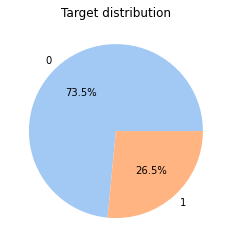

In [39]:
# круговая диаграмма для целевого признака
sns.set_palette('pastel')
plt.title('Target distribution')
data['churn'].value_counts().plot(kind='pie', autopct='%.1f%%', ylabel='');

Наблюдается небольшой дисбаланс классов. Этот факт необходимо будет учесть при разбиении выборки и обучении моделей.

Рассмотрим распределения признаков по группам клиентов (оставшихся и ушедших).

In [40]:
# временный столбец с используемыми сервисами
data['services'] = 'All services'
data.loc[((data['internet_service'] != 'Not used') &
          (data['multiple_lines'] == 'Not used')), 'services'] = 'Internet only'
data.loc[((data['internet_service'] == 'Not used') &
          (data['multiple_lines'] != 'Not used')), 'services'] = 'Phone only'

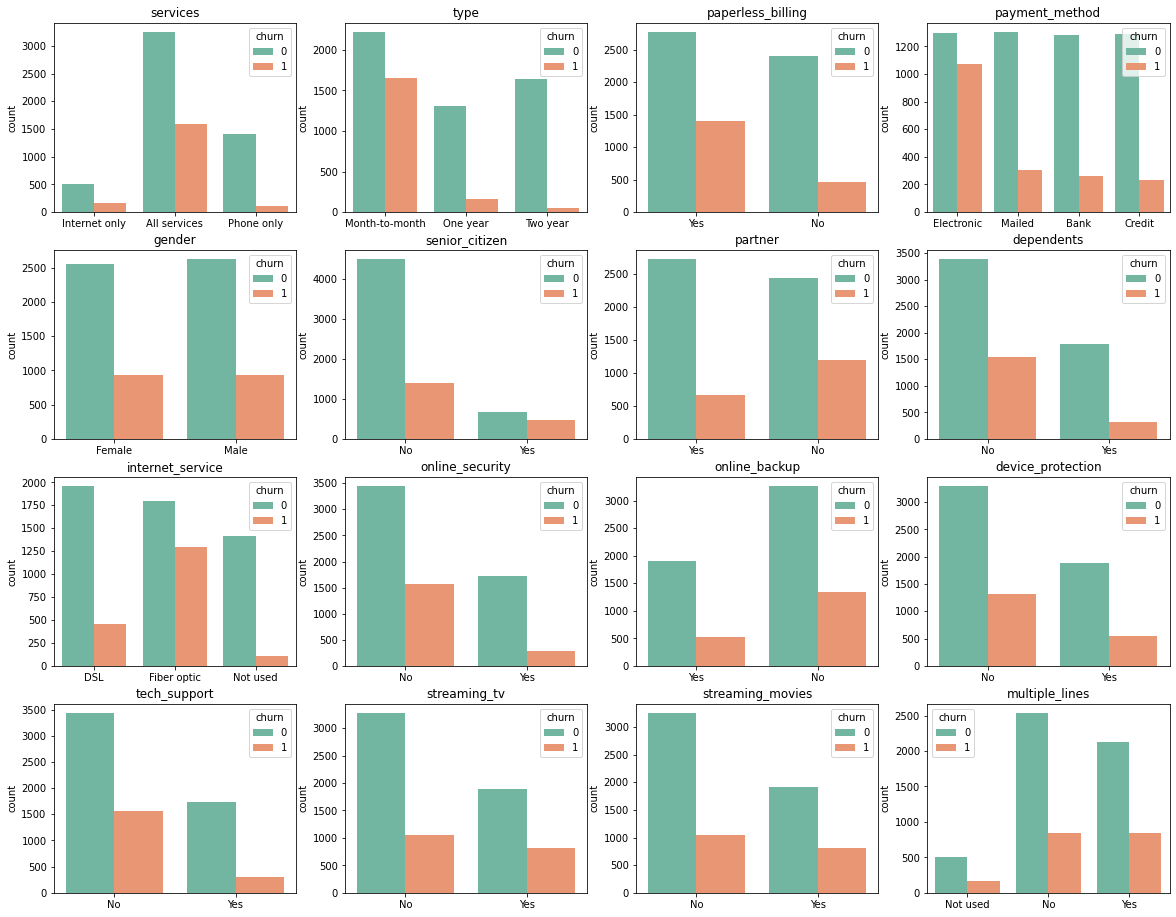

In [41]:
sns.set_palette('Set2')
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))
cols = ['services'] + cat_cols

for row_index, row in enumerate(axes):
    for col_index, _ in enumerate(row):
        cat_index = col_index + 4 * row_index
        # Too long labels in payment_method, so cut it
        x_labels = [name.split()[0] if cols[cat_index] == 'payment_method'
                    else name for name in data[cols[cat_index]].unique()]
        plot = sns.countplot(data=data, x=cols[cat_index], hue='churn',
                             ax=axes[row_index, col_index])
        plot.set_xlabel('')
        plot.set_xticklabels(x_labels)
        plot.set_title(cols[cat_index])

Видно, что среди ушедших пользователей доля тех, кто пользуется только интернетом или только телефонной связью, мала. Однако, можно также заметить, что и среди оставшихся довольно много тех, кто пользуется обеими услугами.

In [42]:
# вспомогательные таблицы по категориям
remaining = data.query('churn == 0')
gone = data.query('churn == 1')

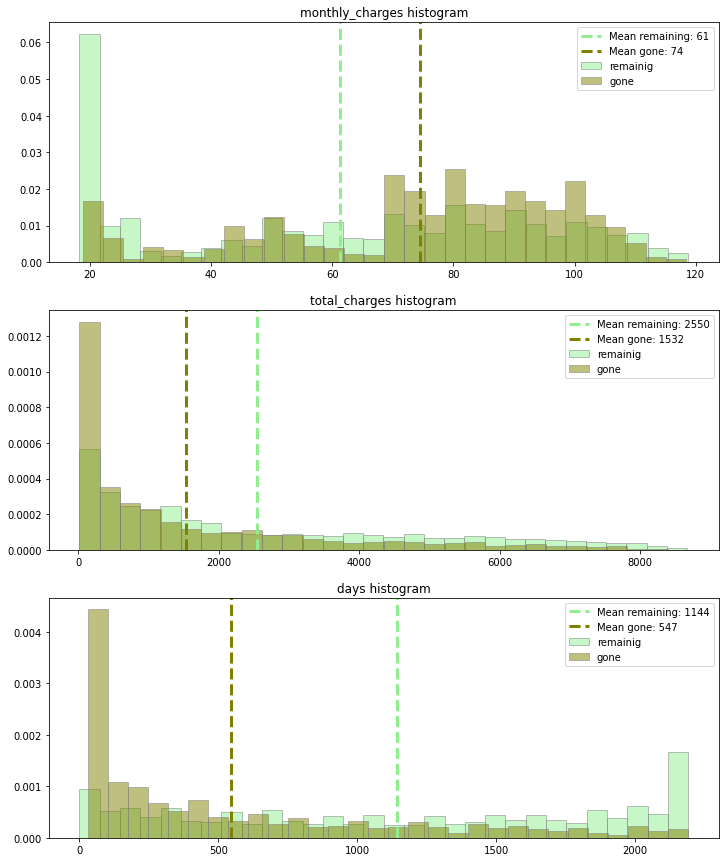

In [43]:
# построение гистограмм числовых признаков по группам клиентов
fig, axes = plt.subplots(nrows=len(num_cols), figsize=(12, 15))
for ax_index, axis in enumerate(axes):
    axis.hist(remaining[num_cols[ax_index]], bins=30, color='lightgreen',
              edgecolor='grey', alpha=0.5, label='remainig', density=True)
    axis.hist(gone[num_cols[ax_index]], bins=30, color='olive',
              edgecolor='grey', alpha=0.5, label='gone', density=True)
    axis.axvline(remaining[num_cols[ax_index]].mean(), color='lightgreen',
                 linestyle='dashed', linewidth=3,
                 label=f'Mean remaining: {remaining[num_cols[ax_index]].mean():.0f}')
    axis.axvline(gone[num_cols[ax_index]].mean(), color='olive',
                 linestyle='dashed', linewidth=3,
                 label=f'Mean gone: {gone[num_cols[ax_index]].mean():.0f}')
    axis.legend()
    axis.set_title(f'{num_cols[ax_index]} histogram')

В среднем ушедшие пользователи ежемесячно тратят на услуги больше, чем те, кто остался. По все видимости, ушедшие пользователи чаще подключают много дополнительных услуг, из-за которых растёт ежемесячных платёж.

Также можно заметить, что клиенты уходят часто спустя довольно короткий промежуток времени, в то время как распределение действующих пользователей по числу дней довольно равномерно.

Посмотрим также на корреляцию признаков, т.к. для использования в линейных моделях классификации необходимо будет избавляться от мультиколлинеарности в данных.

In [44]:
data.drop('services', axis=1, inplace=True)

In [45]:
data[num_cols].corr()

,monthly_charges,total_charges,days
monthly_charges,1.000000,0.651182,0.247754
total_charges,0.651182,1.000000,0.826095
days,0.247754,0.826095,1.000000


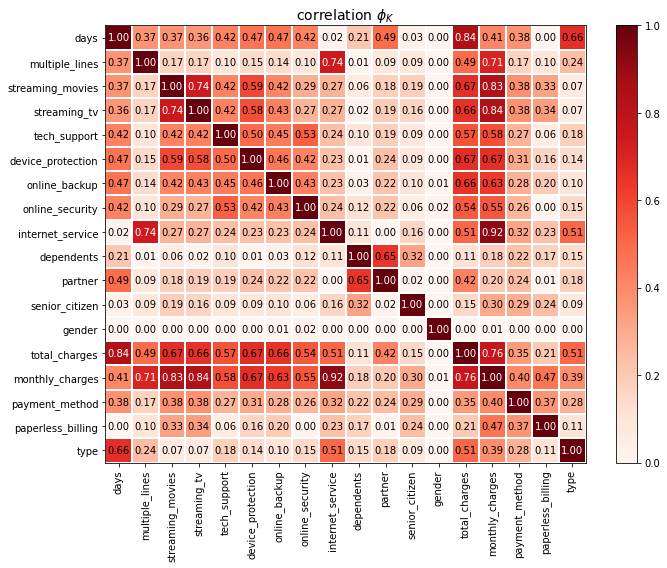

In [46]:
phik_corr = data.drop('churn', axis=1).phik_matrix(interval_cols=num_cols)
phik_corr.round(2)

plot_correlation_matrix(phik_corr.values, 
                        x_labels=phik_corr.columns, 
                        y_labels=phik_corr.index, 
                        vmin=0, vmax=1, color_map="Reds", 
                        title=r"correlation $\phi_K$", 
                        figsize=(10, 8))
plt.tight_layout()

Закономерно прослеживается довольно сильная линейная зависимость между общими тратами и количеством дней и немного более слабая от ежемесячного платежа. Удалим `total_charges`, т.к. в принципе этот параметр можно вычислить из ежемесячных трат и длительности пользования услугами.

In [47]:
data.drop('total_charges', axis=1, inplace=True)
num_cols.remove('total_charges')

Также заметно довольно сильное влияние дополнительных услуг на месячный платёж. Особенно это касается `internet_service`. Можно обратить внимание и на то, что есть несколько признаков, которые довольно слабо коррелируют со всеми остальными, например, `gender` или `senior_citizen`. Однако данный тип корреляции может находить нелинейные зависимости, поэтому предварительно решим не избавляться от кажущихся лишними признаков.

Перейдём к обучению и выбору моделей.

## Обучение и сравнение моделей

In [48]:
# подготовка обучающей и тестовой выборки
(X_train, X_test,
 y_train, y_test) = train_test_split(data.drop('churn', axis=1), data['churn'],
                                     test_size=0.25, random_state=RANDOM_STATE,
                                     stratify=data['churn'])
# проверка разбиения
print(f'Train size = {X_train.shape[0]}')
print(f'Test size = {X_test.shape[0]}')

Train size = 5282
Test size = 1761


### Логистическая регрессия

In [49]:
# предобработка данных по группам признаков
transformers = [
    ('scaler', StandardScaler(), num_cols),
    ('encoder', OneHotEncoder(drop='first'), cat_cols)
]
preprocessor = ColumnTransformer(transformers, remainder='passthrough', n_jobs=-1)

# модель и pipeline
classifier = LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# сетка гиперпараметров
lr_params = {
    'classifier__C': [1000, 100, 10, 1, 0.1, 0.01, 0.001]
}

In [50]:
%%time
lr_searcher = GridSearchCV(pipe, lr_params, scoring='roc_auc',
                           refit=True, n_jobs=-1)
lr_searcher.fit(X_train, y_train)
print(f'Best LogisticRegression ROC-AUC: {lr_searcher.best_score_:.5f}')
print(f'Best LogisticRegression parameters: {lr_searcher.best_params_}')
print()

Best LogisticRegression ROC-AUC: 0.84096
Best LogisticRegression parameters: {'classifier__C': 0.1}

CPU times: total: 328 ms
Wall time: 1.3 s


### RandomForestClassifier

In [51]:
# предобработка данных по группам признаков
transformers = [
    ('encoder', OneHotEncoder(drop='first'), cat_cols)
]
preprocessor = ColumnTransformer(transformers, remainder='passthrough', n_jobs=-1)

# модель и pipeline
classifier = RandomForestClassifier(class_weight='balanced',
                                    random_state=RANDOM_STATE, n_jobs=-1)
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# сетка гиперпараметров
rf_params = {
    'classifier__n_estimators': range(100, 501, 50),
    'classifier__max_depth': range(2, 21, 2),
    'classifier__max_features': ['sqrt', 'log2', None]
}

In [52]:
%%time
rf_searcher = RandomizedSearchCV(pipe, rf_params, scoring='roc_auc',
                                 refit=True, random_state=RANDOM_STATE, n_jobs=-1)
rf_searcher.fit(X_train, y_train)
print(f'Best RandomForest ROC-AUC: {rf_searcher.best_score_:.5f}')
print(f'Best RandomForest parameters: {rf_searcher.best_params_}')
print()

Best RandomForest ROC-AUC: 0.86857
Best RandomForest parameters: {'classifier__n_estimators': 500, 'classifier__max_features': None, 'classifier__max_depth': 10}

CPU times: total: 6.33 s
Wall time: 21.2 s


### CatBoostClassifier

In [53]:
# сетка гиперпараметров
cb_params = {'iterations': list(range(100, 501, 50)),
             'learning_rate': np.arange(0.05, 0.2, 0.05),
             'depth': range(4, 11, 2)
            }
# модель
classifier = CatBoostClassifier(cat_features=cat_cols, logging_level='Silent',
                                eval_metric='AUC:hints=skip_train~false',
                                random_seed=RANDOM_STATE)

In [54]:
%%time
cb_searcher = RandomizedSearchCV(classifier, cb_params, scoring='roc_auc',
                                 refit=True, random_state=RANDOM_STATE, n_jobs=-1)
cb_searcher.fit(X_train, y_train)
print(f'Best CatBoost ROC-AUC: {cb_searcher.best_score_:.5f}')
print(f'Best CatBoost parameters: {cb_searcher.best_params_}')
print()

Best CatBoost ROC-AUC: 0.90838
Best CatBoost parameters: {'learning_rate': 0.2, 'iterations': 450, 'depth': 6}

CPU times: total: 22.1 s
Wall time: 3min 32s


### Сравнение моделей

In [55]:
results = [['LogisticRegression', lr_searcher.best_score_],
           ['RandomForestClassifier', rf_searcher.best_score_],
           ['CatBoostClassifier', cb_searcher.best_score_]]
columns = ['Model', 'ROC-AUC']
table = pd.DataFrame(data=results, columns=columns)
table

,Model,ROC-AUC
0,LogisticRegression,0.840959
1,RandomForestClassifier,0.868569
2,CatBoostClassifier,0.908376


На этапе обучения наилучшие результаты показала модель `CatBoostClassifier` с параметрами `learning_rate=0.2, iteration=450, depth=6`. Будем использовать именно эту модель для итогового тестирования.

## Тестирование модели

In [56]:
model = cb_searcher.best_estimator_
y_test_predicted = model.predict_proba(X_test)[:,1]

In [57]:
test_auc = roc_auc_score(y_test, y_test_predicted)
test_accuracy = accuracy_score(y_test, model.predict(X_test))
print(f'Test ROC-AUC: {test_auc:.5f}')
print(f'Test accuracy: {test_accuracy:.5f}')

Test ROC-AUC: 0.92525
Test accuracy: 0.87961


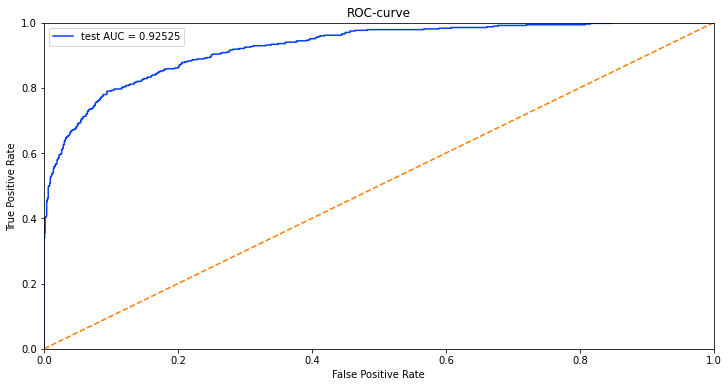

In [58]:
sns.set_palette('bright')
fpr, tpr, thrs = roc_curve(y_test, y_test_predicted) 
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'test AUC = {test_auc:.5f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend()
plt.show()

Таким образом, наилучшая по результатам обучения модель `CatBoostClassifier` на тестовой выборке показала результат `ROC-AUC=0.92` и `accuracy=0.88`.

Рассмотрим важность признаков полученной модели.

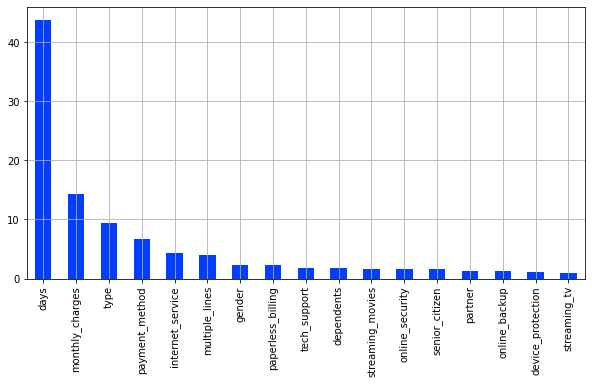

In [59]:
feat_imp = pd.Series(model.feature_importances_, X_train.columns)
plt.figure(figsize=(10, 5))
feat_imp.sort_values(ascending=False).plot(kind='bar');
plt.grid()

Таким образом, из 18 признаков наиболее важными для алгоритма оказались `days`, `monthly_charges`, `type`, `payment_method`, `internet_service` и `multiple_lines`. Остальные характеристики имеют меньшее значение.

## Вывод

На первом этапе данные были загружены и предобработаны (объединены таблицы, заполнены пропуски). Затем была проведена подготовка данных для дальнейшего анализа и обучения моделей (выделен целевой признак, добавлены новые и удалены лишние признаки).

Проведён исследовательский анализ данных. Выявлена несбалансированность выбобрки по целевому признаку. На основани корреляции числовых признаков часть была удалена для устранения мультиколлинеарности.

Выборка была поделена на тренировочную и тестовую. С использованием кросс-валидации были подобраны гиперпараметры и обучены три модели классификации:
 - *LogisticRegression* (с применением *Pipeline* для обработки столбцов перед применением в модели);
 - *RandomForestClassifier*;
 - *CatBoostClassifier*.

На основании полученных резльтатов в качестве итоговой модели был выбран `CatBoostClassifier` с параметрами `learning_rate=0.2, iteration=450, depth=6`. На тестовой выборке эта модель показала результат `ROC-AUC=0.92` и `accuracy=0.88`.

# Отчёт

В ходе выполнения работы была решена задача построения модели, предсказывающей отток клиентов оператора связи. В качестве метрики был выбран ROC-AUC.

Предоставленные входные данные, актуальные на 01.02.2020, содержат следующее:
 - *информация о контрактах* (дата начала пользования услугами, дата окончания пользования услугами, тип оплаты, безналичный расчёт, способ оплаты, ежемесячные траты на услуги, общие траты на услуги);
 - *информация о клиентах* (пол клиента, пенсионный статус, наличие супруга(-и), наличие иждивенцев);
 - *информация об использовании интернет-услуг* (тип подключения, блокировка небезопасных сайтов, резервное копирвоание, антивирус, техническая поддержка, стриминговое телевидение, каталог фильмов);
 - *информация об использовании телефонной связи* (подключение телефона к нескольким линиям).
  

Первоначальный план состоял из следующих пунктов:
 1. *Предобработка данных*
 0. *Исследовательский анализ данных*
 0. *Подготовка данных*
 0. *Обучение и сравнение моделей*
 0. *Тестирование лучшей модели*
 0. *Составление отчёта*
 
После начала работы порядко пунктов *2 (Исследовательский анализ данных)* и *3 (Подготовка данных)* был изменён. В остальном план остался прежним, а все его пункты были реализованы.

**Предобработка данных**

Перед началом работы имеющиеся данные были объединены в общую таблицу по параметру `сustomerID`. Образованные после объединения технические пропуски были заменены на следующие значения:
 - для столбцов `InternetService` и `MultipleLines` -- `Not used` (чтобы подчеркнуть, что определённый вид услуг не был использован вовсе);
 - для прочих столбцов интернет-услуг -- `No`.
 
Пропуски в колонке `TotalCharges`, которые были выражены пробелами, заменены на значения соседнего столбца `MonthlyCharges` (т.к. данные пропуски обнаружены для новых клиентов).

**Подготовка данных**

В предоставленных для исследования данных не был явно указан целевой признак -- факт ухода клиента. Однако эта проблема была решена на основаннии данных в столбце `EndDate`:
 - `Churn = 1`, если в `EndDate` указана дата (т.е. договор расторгнут);
 - `Churn = 0`, если в `EndDate` содержится значение *No* (т.е. договор ещё действует).

Имеющиеся временные признаки были переведены в продолжительность пользования услугами:
 - разница между `EndDate` и `BeginDate` в днях, если договор расторгнут;
 - разница между датой выгрузки данных (01.02.2020) и `BeginDate`, если клиент продолжает пользоваться услугами.

Для недопущения утечки целевого признака, информация о датах (`BeginDate` и `EndDate`) была удалена. Также был удалён `customerID`, т.к. смысловой нагрузки в решаемой задаче этот признак не имеет.

**Исследовательский анализ**

Анализ целевого признака показал наличие дисбаланса классов, что было в дальнейшем учтено при разбиении выборки и обцчении моделей. Анализ распределений остальных признаков, а также их корреляций, показал необходимость также удалить информацию об общих тратах `TotalCharges`, т.к. наблюдалась довольно высокая корреляция этого признака с `MonthlyCharges` и продолжительностью пользования услугами.

**Обучение и сравнение моделей**

После проделанных выше действий к этапу обучения моделей подошли со следующим набором признаков:
 - присутствующие в исходных данных: *Type*, *PaperlessBilling*, *PaymentMethod*, *MonthlyCharges*, *gender*, *SeniorCitizen*, *Partner*, *Dependents*, *InternetService*, *OnlineSecurity*, *OnlineBackup*, *DeviceProtection*, *TechSupport*, *StreamingTV*, *StreamingMovies*, *MultipleLines*;
 - *Days* -- добавленный признак -- продолжительность прользования услугами;
 - *Churn* -- целевой признак -- факт ухода клиента.
 
Как можно заметить, числовыми признаками являются только *MonthlyCharges* и *Days*. Остальные признаки являются категориальными. Данные были разбиты на обучающую и тренировочную выборки в соотношении 3:1.

*Логистическая регрессия*

Для применения признаков в линейных моделях важна предварительная обраотка данных. Чтобы упростить все преобразования было решено использовать `ColumnTransformer`, который применяет `StandardScaler` для чиловых и `OneHotEncoder` для категориальных признаков. Преобразователь вместе с моделью логистической регрессии (для которой указан аргумент `class_weight='balanced'` ввиду несбалансированности выборки) были объединены в `Pipeline`. Подбором параметра `C` (1000, 100, 10, 1, 0.1, 0.01, 0.001) на кросс-валидации удалось получить наилучшее значение метрики `ROC-AUC = 0.84` для параметра `C = 0.1`.

*Случайный лес*

Обучение и подбор параметров модели случайного леса был организован схожим образом с моделью логичтической регресси, за исключением применения нормировщика для числовых признаков, т.к. здесь в этом нет необходимости. Т.е. в пайплайн воли только `OneHotEncoder` для категориальных признаков и `RandomForestClassifier(class_weight='balanced')`. Перебором по параметрам     *'n_estimators': range(100, 501, 50), 'max_depth': range(2, 21, 2), 'max_features': ['sqrt', 'log2', None]* при помощи `RandomizedSearchCV` был получен результат `ROC-AUC = 0.87` при параметрах `'n_estimators': 500, 'max_features': None, 'max_depth': 10`.

*Градиентный бустинг*

Для обучения модели `CatBoostClassifier` особой подготовки признаков не требовалось, достаточно было передать в аргументы модели список категориальных признаков. Для более быстрого подбора параметров среди `'iterations': range(100, 501, 50), 'learning_rate': np.arange(0.05, 0.2, 0.05), 'depth': range(4, 11, 2)` был применён `RandomizedSearchCV`. Наилучший результат `ROC-AUC = 0.91` был достигнут при параметрах `'learning_rate': 0.2, 'iterations': 450, 'depth': 6`.

**Тестирование модели**

По результатам обучения и сравнения моделей лучшей была выбрана модель градиентного бустинга `CatBoostClassifier(learning_rate=0.2, iterations=450, depth=6)`. Результатов тестирования данной модели стало значение метрики `ROC-AUC = 0.92` (при `accuracy = 0.88`).

Таким образом, поставленная задача была успешно выполнена. Существенных трудностей в процессе работы не возникло. Какие-либо явные ключевые этапы, которые позволили добиться высокого результата, выделить сложно т.к. все предпринятые шаги важны: и предобработка с заполнением пропусков, и выделение новых признаков, и удаление лишних по результатам анализа признаков, и сама организация процесса подбора гиперпараметров и обучения моделей.